## Convolution neural networks for classifying different traffic signs

In [ ]:
!pip install opencv-python
!pip install numpy==1.21.2

In [5]:
## Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt ## plotting library
import pandas as pd ## data management and reading library
import random ## module handling random numbers
from sklearn.model_selection import train_test_split ## module for splitting the dataset into training and testing examples
import csv ## module for importing the csv files
import pdb ## importing the python debugger in case of debugging the code
#import resizeimage ## module for resizing image 
from PIL import Image

import cv2
from collections import Counter
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms


## Reading the image dataset 

This helps to read the image dataset and converts them to list of images and the corresponding labels

In [6]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 43 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [8]:
##reading the image dataset
path_of_data=('GTSRB/Training/Images')## path of where the dataset is stored
images,labels=readTrafficSigns(path_of_data)## reading the images

### Processing the image 

The image processing step involves converting the colored image into gray scale as well as transforming all the images in a common scale

In [9]:
grey_image=[]
for items in images:
    img_gray = cv2.cvtColor(items, cv2.COLOR_BGR2GRAY)
    grey_image.append(img_gray)

## resizing the grayscale images:
resized_grey_image=[]
for items in grey_image:
    resized_grey_image.append(cv2.resize(items, (64, 64), interpolation = cv2.INTER_AREA))

## showing an example in the dataset. 

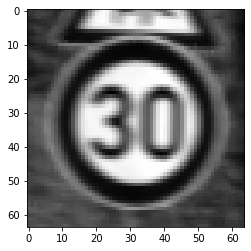

In [10]:
plt.imshow(resized_grey_image[1000], cmap='gray')
plt.show()

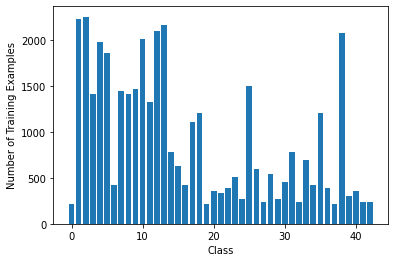

In [11]:
## displaying the distribution of the classes in the dataset 
z=Counter(labels)## counts how many examples are there for each labels
y_pos=range(43)# there are 43 labels so creating an array from 0:42
plt.bar(y_pos,list(z.values()))#plotting the bar
plt.xlabel('Class')
plt.ylabel('Number of Training Examples')
plt.show()#showing the plot



In [12]:
##flattening the image matrix, converting each 64 by 64 matrix to a single length array
processed_images=np.zeros([len(labels),(64*64)])
idx=0
for items in resized_grey_image:
    
    processed_images[idx]=(items.flatten())
    idx+=1
print('Yaba daba du Image Processed !!!')
    

Yaba daba du Image Processed !!!


## Shuffling the dataset and splitting the dataset into Training and the Test set
The datasets are shuffled in order to reduce the class imbalance and the data is split into training and the test set. With 70% of the data used for training and 30% of the data for testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, test_size=0.3, random_state=0) ## ranom state fixes the seed


## CNN architecture and module
Now the dataset is processed for feeding in the examples in a convolution neural network we start initially with a 4 layer network, where we used Batch normalisation in order to reduce the overfitting. We used Rectification Linear Unit (RELU) activation function for the nodes. Finally in order to use adaptive learning rates we have chosen ADAM optimizer in order to optimize the network

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(2))
             
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=5, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(4096,43)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out=self.layer3(out)
        #out=self.layer4(out)
        out = out.view(out.size(0), -1)
        #print(out.size())
        out = self.fc(out)
        return out

### Convering all the arrays and lists into Tensors to that has to be fed in the model 
In this part we will be converting all the arrays and the list of examples for both the training and the test dataset to tensors, after that we can only feed everythin into the neural network module 


In [15]:
batch_size=120


train_set=X_train.astype(np.float32).reshape(-1,1,64,64)
test_set=X_test.astype(np.float32).reshape(-1,1,64,64)

X_train=torch.Tensor(train_set)
X_test=torch.Tensor(test_set)
y_train=np.array(y_train)
y_train=y_train.astype(np.float32)
y_train=torch.Tensor(y_train)

y_test=np.array(y_test)
y_test=y_test.astype(np.float32)
y_test=torch.Tensor(y_test)
train=torch.utils.data.TensorDataset(X_train,y_train)
test=torch.utils.data.TensorDataset(X_test,y_test)
train_set_dataloader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=False)
test_set_dataloader=torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=False)


### Running the model

In [ ]:
num_epochs=13
train_accu=[]
cnn = CNN()## loading the cnn class constructed above
cnn.train()
if torch.cuda.is_available():
    cnn.cuda() ## using the gpu in the system, do not worry if your system does not have the gpu it will automatically select cpu
all_loss=[]

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_set_dataloader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
            
        #print(images.size())
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        #pdb.set_trace():
        
        
        
    
        outputs = cnn(images)
        
        loss = criterion(outputs, labels.long())
                         
        loss.backward()
        optimizer.step()
        
        
       # prediction = outputs.data.max(1)[1]   # first column has actual prob.
        #accuracy = prediction.eq(labels.data).sum()/batch_size*100
        #train_accu.append(accuracy)
        #if i % 1000 == 0:
         #   print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data[0], accuracy))
        #i += 1
        if (i+1) % 100 == 0:
            all_loss.append(loss.data[0])
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0]))

In [ ]:
plt.plot(all_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('CNN loss with number of Iterations')
plt.show()